In [1]:
from math import cos,sin
import pandas as pd
import numpy as np
import cv2
import mediapipe
import matplotlib.pyplot as plt

# Load the models

In [2]:
import joblib
model_pitch = joblib.load('model_pitch.pkl')
model_yaw = joblib.load('model_yaw.pkl')
model_roll = joblib.load('model_roll.pkl')

In [3]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [4]:
selected_indices = [0, 1, 4, 5, 6, 8, 9, 10, 280, 50, 123, 352, 164, 225, 359, 173, 398, 152, 185, 270, 434, 214, 172, 364]

def get_selected_features(df, selected_indices, default_features = []):
    list = default_features
    for i in sorted(selected_indices):
        list.append('x_'+str(i))
        list.append('y_'+str(i))
    return df.loc[:,list]

# center all points around the nose
def normalize_landmarks(df, selected_indices=np.arange(0,468,1),nose_index=5 , chain_index=152):
    nose_x = df['x_'+str(nose_index)]
    nose_y = df['y_'+str(nose_index)]

    for i in selected_indices:
        df['x_'+str(i)] = df['x_'+str(i)] - nose_x
        df['y_'+str(i)] = df['y_'+str(i)] - nose_y


    # scale all the points by the distance from the nose to the chin
    chin_x = df['x_'+str(chain_index)]
    chin_y = df['y_'+str(chain_index)]
    distance = np.sqrt(chin_x**2 + chin_y**2)

    for i in selected_indices:
        df['x_'+str(i)] = df['x_'+str(i)] / distance
        df['y_'+str(i)] = df['y_'+str(i)] / distance
    
    return df



# Predict the pose of the Face

In [5]:
def predict_pose(image, model_pitch, model_yaw, model_roll, selected_indices, faceModule, static_image_mode=True,max_num_faces=4,show_image=True):
    with faceModule.FaceMesh(static_image_mode=static_image_mode,max_num_faces=max_num_faces) as faces:
        image_faces = {}
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            nose_landmark_list = []
            
            for face_index,face in enumerate(results.multi_face_landmarks):
                image_faces["face_" + str(face_index)] = {}
                nose_landmark = None

                for index, landmark in enumerate(face.landmark):

                    x = landmark.x * image.shape[1]
                    y = landmark.y * image.shape[0]
                    # If the current landmark is the nose landmark, save its coordinates
                    if index == 5:
                        nose_landmark = (x, y)
                    image_faces["face_" + str(face_index)]["x_"+str(index)] = x
                    image_faces["face_" + str(face_index)]["y_"+str(index)] = y
                nose_landmark_list.append(nose_landmark)
            
            image_faces = pd.DataFrame.from_dict(image_faces,orient='index').reset_index()
            image_faces = image_faces.drop(columns=['index'])
            image_faces = get_selected_features(image_faces, selected_indices, default_features = [])
            image_faces = normalize_landmarks(image_faces, selected_indices)
            
            pitch = model_pitch.predict(image_faces)
            yaw = model_yaw.predict(image_faces)
            roll = model_roll.predict(image_faces)

            # Draw axis on the frame for all faces
            for i in range(len(image_faces)):
                image = draw_axis(image, pitch[i], yaw[i], roll[i], nose_landmark_list[i][0], nose_landmark_list[i][1])
            if show_image:
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
            return image

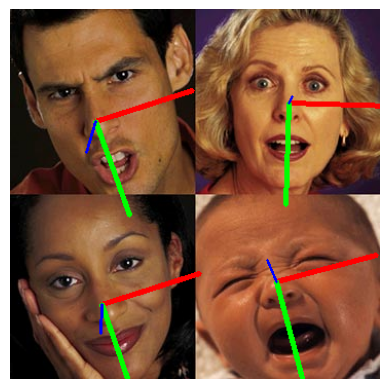

In [6]:
faceModule = mediapipe.solutions.face_mesh

photo_path= "test-1.jpg"
image = cv2.imread(photo_path)

image = predict_pose(image, model_pitch, model_yaw, model_roll, selected_indices, faceModule, static_image_mode=True,max_num_faces=4,show_image=True)

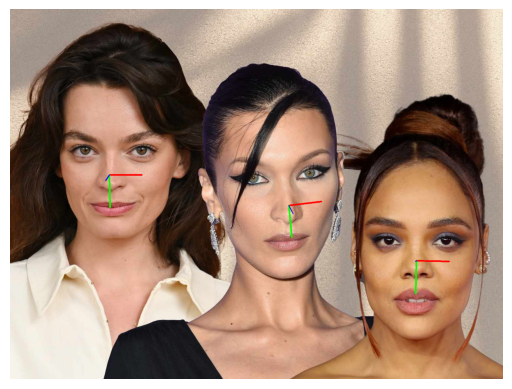

In [7]:
photo_path= "test-2.jpg"
image = cv2.imread(photo_path)

image = predict_pose(image, model_pitch, model_yaw, model_roll, selected_indices, faceModule, static_image_mode=True,max_num_faces=4,show_image=True)

# Reproduce the video with the pose of the face

In [11]:
input_video_path = 'test-coca.mp4'
output_video_path = 'output_video.mp4'

faceModule = mediapipe.solutions.face_mesh

cap = cv2.VideoCapture(input_video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'AVC1')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_with_axis = predict_pose(frame, model_pitch, model_yaw, model_roll, selected_indices, faceModule, static_image_mode=False,max_num_faces=4,show_image=False)

    
    out.write(frame_with_axis)

cap.release()
out.release()
cv2.destroyAllWindows()

In [10]:
# capture live stream
faceModule = mediapipe.solutions.face_mesh
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_with_axis = predict_pose(frame, model_pitch, model_yaw, model_roll, selected_indices, faceModule, static_image_mode=False,max_num_faces=4,show_image=False)

    if frame_with_axis is not None:
        cv2.imshow('Frame', frame_with_axis)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()